*This notebook was created by Sergey Tomin (sergey.tomin@desy.de). Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). June 2019.*

## PFS tutorial N1. Synchrotron radiation module.

Synchrotron radiation module is also included to the OCELOT multiphysics simulation toolkit .

The OCELOT SR module is capable of calculating spectrum and spatial distribution of spontaneous radiation from a single electron in a magnetic field defined by file data (field on an insertion device axis or 3D magnetic field map) or using standard elements as Undulator with arbitrary defined period, length and $K$.

Some details about SR module can be found in [S. Tomin, G. Geloni, Synchrotron Radiation Module in OCELOT Toolkit](http://accelconf.web.cern.ch/AccelConf/ipac2019/papers/wepts017.pdf)

### Contents
1. [Ideal magnetic field](#ideal)
    * [Spatial distribution](#spatial)
        - [Phase](#phase)
    * [Spectrum](#spectrum)
    * [3D spatial distribution](#3d_spatial)
2. [Magnetic Field map on the undulator axis](#field_map)
3. [Radiation from a Bending Magnet](#BM)

<a id='ideal'></a>
## Ideal magnetic field

To estimate SR from undulator you can use ideal sinus like magnetic field 
$$B_y(x, y, z) = B_0 \sin(\lambda_u z)$$ 
with $B_x(x, y, z) = B_z(x, y, z) = 0$. In that case, we can use **Undulator** element with standard parameters like $K$, period length, number of periods. 


In [1]:
# To activate interactive matplolib in notebook
#%matplotlib notebook

In [1]:
# import main functions from Synchrotron Radation (SR) module 
from ocelot.rad import *
# import OCELOT main functions 
from ocelot import *
# import OCELOT plotting functions 
from ocelot.gui import *
import time

initializing ocelot...


As usual we start from creating elements and lattice. 

At the moment SR module recognize only **Undulator** element. Even if you want to calculate radiation from dipole magnet. 

In [2]:
und = Undulator(Kx=0.43, nperiods=500, lperiod=0.007, eid="und")

lat = MagneticLattice((und))

To calculate radiation one needs two additional objects
* ```Beam()``` 
to provide the electron beam energy and beam current. 
<div class="alert alert-block alert-warning">
<b>Note:</b> The earlier version of SR solver could calculate emittance and energy spread effect. In current version, we focus on single electron radiation. Although, these effects can be added to subsequent releases.  </div>

* ```Screen()```  class to store radiation field and to provide information about screen parameters where radiation will be observed.

<a id='spatial'></a>
### Spatial distribution

To calculate spatial distribution we need to define screen size(s) and number of points in each planes.
We start with simplest 1D case. 

In [3]:
beam = Beam()
beam.E = 2.5            # beam energy in [GeV]
beam.I = 0.1            # beam current in [A]


screen = Screen()
screen.z = 100.0      # distance from the begining of lattice to the screen 
screen.size_x = 0.002 # half of screen size in [m] in horizontal plane
screen.size_y = 0.    # half of screen size in [m] in vertical plane
screen.nx = 101       # number of points in horizontal plane 
screen.ny = 1         # number of points in vertical plane 


screen.start_energy = 7761.2 # [eV], starting photon energy
screen.end_energy = 7900     # [eV], ending photon energy
screen.num_energy = 1        # number of energy points[eV]

#### Calculate SR 
to calculate SR from one electron there is a function:

```screen = calculate_radiation(lat, screen, beam)```

* ```lat```: MagneticLattice should include element Undulator
* ```screen```: Screen class
* ```beam```: Beam class, the radiation is calculated from one electron

Optional parameters:

* ```energy_loss```: False, if True includes energy loss after each period
* ```quantum_diff```: False, if True introduces random energy kick
* ```accuracy```: 1,  scale for trajectory points number 
* ```end_poles```: False, if True includes end poles with 1/4, -3/4, 1, ... 

In [4]:
start = time.time()
screen = calculate_radiation(lat, screen, beam)
print("time exec: ", time.time() - start, " sec")

time exec:  3.962146759033203  sec


Electric field is stored in 1D arrays

* ```screen.arReEx```: array, Real part of horizontal component of the electric field
* ```screen.arImEx```: array, Imaginary part of horizontal component of the electric field
* ```screen.arReEy```: array, Real part of the vertical component of the electric field
* ```screen.arImEy```: array, Imaginary part of the vertical component of the electric field
* ```screen.arPhase```: array, phase between Re and Im components

Also, **Screen** has coordinates where radiation was calculated 

* ```screen.Xph```, 1D array with coordinates in horizontal plane 
* ```screen.Yph```, 1D array with coordinates in vertical plane
* ```screen.Eph```, 1D array with coordinates in energetic plane

Photon flux is calculated from the electric field and stored in 1D arrays:

* ```screen.Sigma```: horizontal polarization component in $\left[\frac{ph}{sec \cdot mm^2 10^{-3}BW}\right]$
* ```screen.Pi```: vertical polarization component in $\left[\frac{ph}{sec \cdot mm^2 10^{-3}BW}\right]$
* ```screen.Total = screen.Sigma + screen.Pi ```: total flux density in $\left[\frac{ph}{sec \cdot mm^2 10^{-3}BW}\right]$

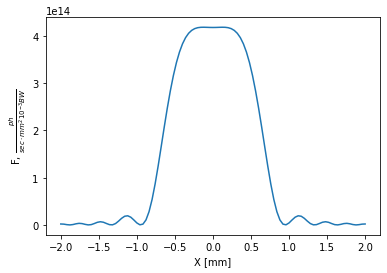

In [5]:
plt.figure(10)
plt.plot(screen.Xph, screen.Total)
plt.ylabel(r"F, $\frac{ph}{sec \cdot mm^2 10^{-3}BW}$")
plt.xlabel(r"X [mm]")
plt.show()

### Plotting utils
you can use standard plotting function 

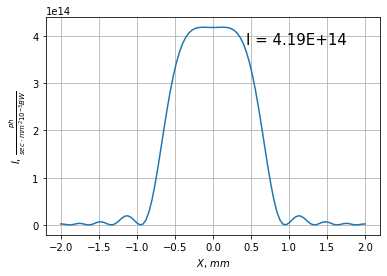

In [6]:
show_flux(screen, unit="mm")

### in [mrad] 

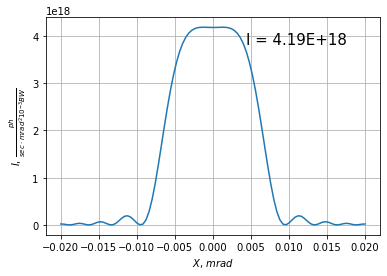

In [7]:
show_flux(screen, unit="mrad",  nfig=2)

<a id='phase'></a>

### Phase
$$
$$
Relation between the time $\tau$ at the observer and the time $t$ of emission

\begin{equation}
\tau(t) = t + \frac{1}{c}\big|\vec{x_{scr}} - \vec{r(t)}\big| = \tau_0 + \int_0^t{\left[1 - \vec{n(t')} \vec{\beta(t')} \right]dt'}
\end{equation}
where $\vec{x_{scr}} = [x_{scr}, y_{scr}, z_{scr}]$

\begin{equation}
\phi(z, \vec{x_{scr}}) = \frac{2\pi c}{\lambda}\tau(t(z)) = \frac{2\pi }{\lambda}\left(c t(z) + \big|\vec{x_{scr}} - \vec{r(z)}\big|\right)
\end{equation}

\begin{equation}
\phi(z, \vec{x_{scr}}) = \phi(z_0, \vec{x_{scr}}) + \frac{2\pi }{\lambda}\int_{z_0}^z{\frac{dz'}{\sqrt{\beta^2  - \beta^2_x(z') - \beta_y^2(z')}}} + \frac{2\pi }{\lambda}\big|\vec{x_{scr}} - \vec{r(z)}\big| - \frac{2\pi }{\lambda}\big|\vec{x_{scr}} - \vec{r(z_0)}\big| 
\end{equation}

where 
\begin{equation}
\phi(z_0, \vec{x_{scr}}) = \frac{2\pi c }{\lambda} t(z_0)+  \frac{2\pi }{\lambda}\big|\vec{x_{scr}} - \vec{r(z_0)}\big| 
\end{equation}
$\vec{r(z)}= [x(z), y(z), z]$ is the electron trajectory, 

Using assumptions:
\begin{equation}
\begin{split}
&\gamma >> 1, \qquad |\beta_x|<< 1, \qquad |\beta_y|<<1 \\
(z_{scr} - z_0) >> (z - z_0), &\qquad (z_{scr} - z_0) >> (x_{scr} - x(z)), \qquad (z_{scr} - z_0) >> (y_{scr} - y(z))
\end{split}
\end{equation}

we finally get 
\begin{equation}
\begin{split}
\phi(z, \vec{x_{scr}}) = \phi(z_0, \vec{x_{scr}}) + \frac{\pi}{\lambda \gamma^2}\left[(z - z_0) + \gamma \int_{z_0}^z\left\{\beta_x^2(z') + \beta_y^2(z')\right\}dz' + 
\gamma^2 \left[\frac{(x_{scr} - x(z))^2}{z_{scr} - z} - \frac{(x_{scr} - x(z_0))^2}{z_{scr} - z_0}\right] + 
\gamma^2 \left[\frac{(y_{scr} - y(z))^2}{z_{scr} - z} - \frac{(y_{scr} - y(z_0))^2}{z_{scr} - z_0}\right]\right]
\end{split}
\end{equation}

During calculation of the radiation we assume $\phi(z_0, \vec{x_{scr}}) = 0$. 

At the last step in the function ```calculate_radiation``` method ```screen.add_fast_oscilating_term(x0=0, y0=0, z0=0)``` is called which adds the subtracted term. 


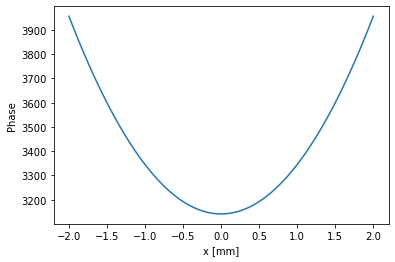

In [8]:
plt.figure(1000)
plt.plot(screen.Xph, screen.arPhase)
plt.xlabel("x [mm]")
plt.ylabel("Phase")
plt.show()

<a id='spectrum'></a>
## Spectrum 

The same way to calculate on-axis spectrum 

time exec:  1.7017252445220947  sec


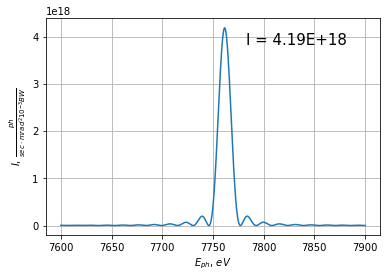

In [9]:
beam = Beam()
beam.E = 2.5            # beam energy in [GeV]
beam.I = 0.1            # beam current in [A]


screen = Screen()
screen.z = 100.0      # distance from the begining of lattice to the screen 


screen.start_energy = 7600     # [eV], starting photon energy
screen.end_energy = 7900       # [eV], ending photon energy
screen.num_energy = 1000       # number of energy points[eV]

# Calculate radiation 
start = time.time()
screen = calculate_radiation(lat, screen, beam)
print("time exec: ", time.time() - start, " sec")

# show result
show_flux(screen, unit="mrad",  nfig=12)

<a id='3d_spatial'></a>
## 2D spatial distribution

time exec:  2.863615036010742  sec


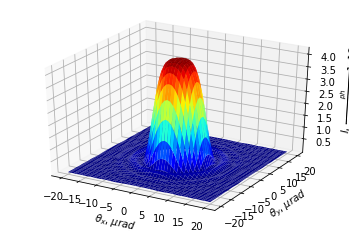

In [10]:
beam = Beam()
beam.E = 2.5            # beam energy in [GeV]
beam.I = 0.1            # beam current in [A]


screen = Screen()
screen.z = 100.0        # distance from the begining of lattice to the screen 
screen.size_x = 0.002   # half of screen size in [m] in horizontal plane
screen.size_y = 0.002   # half of screen size in [m] in vertical plane
screen.nx = 51          # number of points in horizontal plane 
screen.ny = 51          # number of points in vertical plane 


screen.start_energy = 7761.2 # [eV], starting photon energy
screen.end_energy = 7900     # [eV], ending photon energy
screen.num_energy = 1        # number of energy points[eV]

start = time.time()

# Calculate radiation 
screen = calculate_radiation(lat, screen, beam)
print("time exec: ", time.time() - start, " sec")

# show result
show_flux(screen, unit="mrad",  nfig=13)

## 3D distribution in arbitrary domains
see tutorial [PFS tutorial N4. Converting synchrotron radiation results from Screen object to RadiationField](pfs_4_synchrotron_radiation_visualization.ipynb)

<a id='field_map'></a>
# Magnetic Field map on the undulator axis

At the moment, spatial coordinates must be in [mm]. Field map can have 3 formats:
1. Planar undulator. 2 columns in the file. The first column is longitudinal coordinates in [mm] and second the vertical magnetic field in [T]. [Z, By]
2. Spiral undulator. 3 columns in the file. The first column is longitudinal coordinates in [mm] and second the horizontal magnetic field and vertical in [T]. [Z, Bx, By]
3. 3D magnetic field. [x, y, z, Bx, By, Bz]

## Planar undulator. 
First off we will generate magnetic field. 


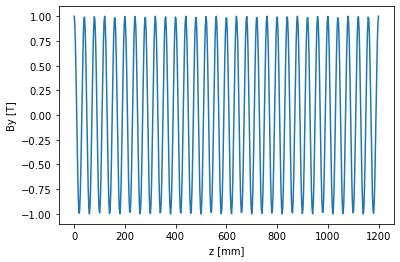

In [11]:
lperiod = 0.04 # [m] undulator period 
nperiods = 30  # number of periods
B0 = 1         # [T] amplitude of the magnetic field

# longitudinal coordinates from 0 to lperiod*nperiods in [mm] 
z = np.linspace(0, lperiod*nperiods, num=500)*1000 # [mm] 
lperiod_mm = lperiod * 1000 # in [mm]
By = B0*np.cos(2*np.pi/lperiod_mm*z)

plt.figure(100)
plt.plot(z, By)
plt.xlabel("z [mm]")
plt.ylabel("By [T]")
plt.show()

### Save the map into a file 


In [12]:
filed_map = np.vstack((z, By)).T

np.savetxt("filed_map.txt", filed_map)

Create undulator element with field map and initialize MagneticLattice

In [13]:
und_m = Undulator(field_file="filed_map.txt", eid="und")

lat_m = MagneticLattice((und_m))

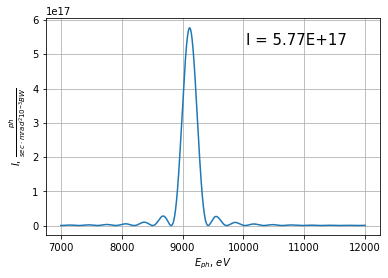

In [14]:
beam = Beam()
beam.E = 17.5            # beam energy in [GeV]
beam.I = 0.1            # beam current in [A]


screen = Screen()
screen.z = 1000.0      # distance from the begining of lattice to the screen 


screen.start_energy = 7000      # [eV], starting photon energy
screen.end_energy = 12000       # [eV], ending photon energy
screen.num_energy = 1000        # number of energy points[eV]

# Calculate radiation 
screen = calculate_radiation(lat_m, screen, beam)

# show result
show_flux(screen, unit="mrad",  nfig=103)

### Estimation radiation properties 
We can estimate radiation properties using function:

```print_rad_props(beam, K, lu, L, distance)```
* ```beam``` is Beam class
* ```K``` is undulator parameter
* ```lu``` is undulator period in [m]
* ```L``` is undulator length in [m]
* ```distance``` is distance to the screen in [m]

Also we have simple functions which can translate one undulator parameter to another, like:

```field2K(field, lu=0.04)```

In [15]:
K = field2K(field=B0, lu=lperiod)
print_rad_props(beam, K, lu=lperiod, L=lperiod*nperiods, distance=screen.z)

********* ph beam ***********
Ebeam        :  17.5  GeV
K            :  3.7349164279988596
B            :  1.0  T
lambda       :  1.35992E-10  m 
Eph          :  9.11702E+03  eV
1/gamma      :  29.1999  um
sigma_r      :  1.4376  um
sigma_r'     :  7.5275  urad
Sigma_x      :  1.4376  um
Sigma_y      :  1.4376  um
Sigma_x'     :  7.5275 urad
Sigma_y'     :  7.5275 urad
H. spot size :  7.5275 / 0.0075  mm/mrad
V. spot size :  7.5275 / 0.0075  mm/mrad
I            :  0.1  A
Nperiods     :  30.0
distance     :  1000.0  m
flux tot     :  2.05E+14  ph/sec/0.1%BW
flux density :  5.76E+17  ph/sec/mrad^2/0.1%BW;    5.76E+11  ph/sec/mm^2/0.1%BW
brilliance   :  4.44E+22  ph/sec/mrad^2/mm^2/0.1%BW


In [16]:
K = field2K(field=B0, lu=lperiod)
beam = Beam()
beam.E = 0.13
beam.I = 0.1

print_rad_props(beam, K=20, lu=0.2, L=lperiod*20, distance=100)

********* ph beam ***********
Ebeam        :  0.13  GeV
K            :  20
B            :  1.071  T
lambda       :  3.10563E-04  m 
Eph          :  3.99224E-03  eV
1/gamma      :  3930.7605  um
sigma_r      :  1773.8821  um
sigma_r'     :  13932.0371  urad
Sigma_x      :  1773.8821  um
Sigma_y      :  1773.8821  um
Sigma_x'     :  13932.0371 urad
Sigma_y'     :  13932.0371 urad
H. spot size :  1393.2048 / 13.932  mm/mrad
V. spot size :  1393.2048 / 13.932  mm/mrad
I            :  0.1  A
Nperiods     :  4.0
distance     :  100  m
flux tot     :  2.77E+13  ph/sec/0.1%BW
flux density :  2.27E+10  ph/sec/mrad^2/0.1%BW;    2.27E+06  ph/sec/mm^2/0.1%BW
brilliance   :  1.15E+09  ph/sec/mrad^2/mm^2/0.1%BW


## Arbitrary magnetic field map - pythonic way

In OCELOT there is a way to define the 3D magnetic fields as a function. 

Let's consider above example with field map in the file. But this time we will use another approach.

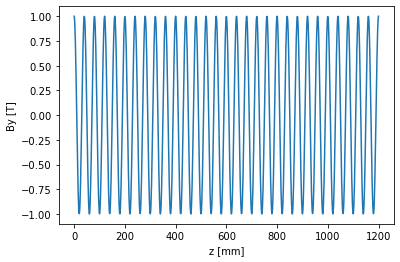

In [17]:
lperiod = 0.04 # [m] undulator period 
nperiods = 30  # number of periods
B0 = 1         # [T] amplitude of the magnetic field

# longitudinal coordinates from 0 to lperiod*nperiods in [mm] 
z = np.linspace(0, lperiod*nperiods, num=1000)*1000 # [mm] 
By = B0*np.cos(2*np.pi/lperiod*z)


def py_mag_field(x, y, z, lperiod, B0):
    """
    x, y, z = coordinates
    """
    Bx = 0
    By = B0*np.cos(2*np.pi/lperiod*z)
    Bz = 0
    return (Bx, By, Bz)



plt.figure(110)
plt.plot(z, py_mag_field(x=0, y=0, z=z, lperiod=lperiod, B0=B0)[1])
plt.xlabel("z [mm]")
plt.ylabel("By [T]")
plt.show()

### Attribute ```mag_field``` 
```Undulator``` element has the attribute   ```mag_field``` , which takes on the function as follows:
```(Bx, By, Bz) = f(x, y, z)```.

For example, we define only the vertical magnetic field and other components are zero:
``` python
field = lambda x, y, z: (0, cos(kz * z), 0)
```

In case, the attribute mag_field is a function, you still need to define ```lperiod``` and ```nperiods``` in the ```Undulator```. It will allow to calculate the length of the undulator. 

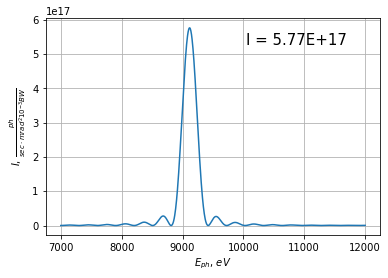

In [18]:

und_m = Undulator(lperiod=lperiod, nperiods=nperiods, Kx=0.0,eid="und")
und_m.mag_field = lambda x, y, z: py_mag_field(x, y, z, lperiod=lperiod, B0=B0)

# next, all the same.

lat_m = MagneticLattice((und_m))


beam = Beam()
beam.E = 17.5            # beam energy in [GeV]
beam.I = 0.1            # beam current in [A]


screen = Screen()
screen.z = 1000.0      # distance from the begining of lattice to the screen 


screen.start_energy = 7000      # [eV], starting photon energy
screen.end_energy = 12000       # [eV], ending photon energy
screen.num_energy = 1000        # number of energy points[eV]

# Calculate radiation 
screen = calculate_radiation(lat_m, screen, beam, accuracy=2)

# show result
show_flux(screen, unit="mrad",  nfig=104)

### Accuracy and number of trajectory points 
As it was pointed out above, the function ```calculate_radiation``` has argument ```accuracy=1``` which scales number of trajectory points. 
In the current version of ocelot (19.06) the number of points is calculated by simple expression:
```python
n = int((undul_length*1500 + 100)*accuracy)
```
### Trajectory

The object ```Screen``` after the radiation calculation contains the electron trajectory what was used in a special object ```BeamTraject``` which is attached to:

> screen.beam_traj = BeamTraject()

To retrieve trajectory you need to specify number of electron what you are interested, for example: 
> x = screen.beam_traj.x(n=0)

**for more details have a look to Tutorial #10 "Simple accelerator based THz source"**


In case of ```calculate_radiation``` the ```BeamTraject``` contains only one trajectory, so ```n = 0```

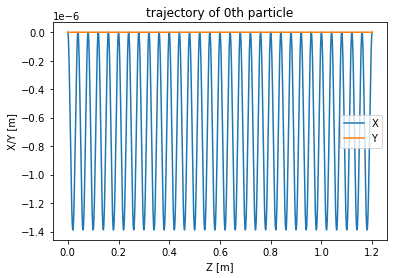

Number of trajectory points n=3800


In [19]:
n = 0
x = screen.beam_traj.x(n)
y = screen.beam_traj.y(n)
z = screen.beam_traj.z(n)
plt.title("trajectory of " + str(n)+"th particle")
plt.plot(z, x, label="X")
plt.plot(z, y, label="Y")
plt.xlabel("Z [m]")
plt.ylabel("X/Y [m]")
plt.legend()
plt.show()

print(f"Number of trajectory points n={len(z)}")

<a id='BM'></a>
# Radiation from bendig magnet

OCELOT currently does not have a direct and simple method for calculating radiation from a dipole magnet. However, there is still a way, albeit with some annoying details which we will demostrate.

As was mentioned above, the ```Undulator``` element has a atribute ```mag_field``` which we will use to simulate magnetic field of a bending magnet. 

Let's assume we have a bending magnet with $B_y = 1$ T amplitude of magnetic field

In [20]:
By = 1. # T - amplitude of vertical magnetic field. 

b = Undulator(lperiod=0.10, nperiods=10, eid="und")
b.mag_field = lambda x, y, z: (0, By, 0)

# in the Undulator element parameters lperiod and nperiods are needed 
# just for definition of the length of the element
d = Drift(l=1)
lat_b = MagneticLattice((b,))


beam = Beam()
beam.E = 2            # beam energy in [GeV]
beam.I = 0.1            # beam current in [A]


screen = Screen()
screen.z = 1000.0      # distance from the begining of lattice to the screen 


screen.start_energy = 100      # [eV], starting photon energy
screen.end_energy = 20000       # [eV], ending photon energy
screen.num_energy = 1000        # number of energy points[eV]

# Calculate radiation 
start = time.time()
screen = calculate_radiation(lat_b, screen, beam, accuracy=5)
print("time exec: ", time.time() - start)

time exec:  3.1381287574768066


### Display the electron trjectory

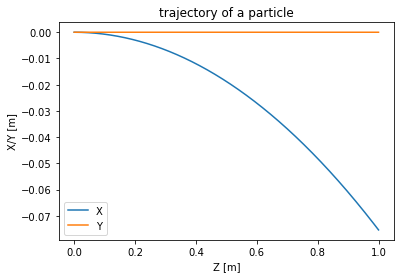

In [21]:
x = screen.beam_traj.x(0)
y = screen.beam_traj.y(0)
z = screen.beam_traj.z(0)
plt.title("trajectory of a particle")
plt.plot(z, x, label="X")
plt.plot(z, y, label="Y")
plt.xlabel("Z [m]")
plt.ylabel("X/Y [m]")
plt.legend()
plt.show()

As we see, the electron has zero initial coordinates and moves along a circular path in the dipole. At the same time, we must remember that the point at which we observe the radiation has the coordinates (Screen.x, Screen.y, Screen.z) = (0, 0, 1000) m.

<div class="alert alert-block alert-warning">
<b>Note:</b> If one wants to calculate radiation from the bunch of electrons (with non trivial phase space distribution) from a bending magnet, one should remember two different coordinate systems for calculating the beam dynamics and calculating the radiation. Currently, a general recommendation is to track the beam to the bending magnet, and then caclualte the radiation. See details in Tutorial N9. Simple accelerator based THz source. </div> 



In order to observe radiation from the central part of the magnet we will modify initial coordinates of the electron beam. But first, find them.

In [22]:
# the beam momentum 
p = np.sqrt(beam.E**2 - m_e_GeV**2)/speed_of_light

# radius of the trajectory in the bending magnet
R = p*1e9 /By
print("R = ", R, " m")

# angle of the bend
phi = np.arcsin(1 / R)
print("analitical silotion: phi = ", phi, " rad")
print("numerical solution: phi ", np.abs(screen.beam_traj.xp(0)[-1]), " rad")

# offset 
x_off = R * (1 - np.cos(phi/2)) 
print("Offset in X direction: ", x_off, " m")



R =  6.671281686212527  m
analitical silotion: phi =  0.15046332005984778  rad
numerical solution: phi  0.151609149365928  rad
Offset in X direction:  0.018870166315482287  m


## Recalculate radiation with new initial coordinates

time exec:  2.4555230140686035


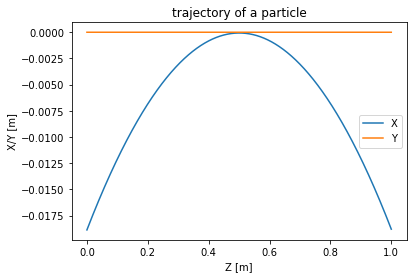

In [23]:
beam = Beam()
beam.E = 2            # beam energy in [GeV]
beam.I = 0.1            # beam current in [A]

# set new initial coordinates for the beam
beam.xp = phi/2  # initial angle x'
beam.x = -x_off  # initial offset 


screen = Screen()
screen.z = 1000.0      # distance from the begining of lattice to the screen 

screen.start_energy = 100      # [eV], starting photon energy
screen.end_energy = 20000       # [eV], ending photon energy
screen.num_energy = 500        # number of energy points[eV]


# Calculate radiation 
start = time.time()
screen = calculate_radiation(lat_b, screen, beam, accuracy=6)
print("time exec: ", time.time() - start)

# display trajectory
x = screen.beam_traj.x(0)
y = screen.beam_traj.y(0)
z = screen.beam_traj.z(0)
plt.title("trajectory of a particle")
plt.plot(z, x, label="X")
plt.plot(z, y, label="Y")
plt.xlabel("Z [m]")
plt.ylabel("X/Y [m]")
plt.legend()
plt.show()

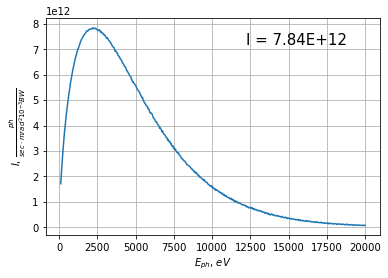

In [24]:
# show result
show_flux(screen, unit="mrad",  nfig=204, xlog=False, ylog=False)

## Show Flux density and compare the result with SPECTRA 

The same setup was simulated with [SPECTRA](http://spectrax.org/spectra/) and saved in "bm_spectra.dc0"

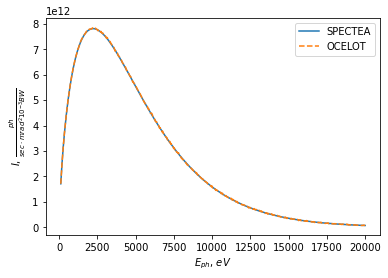

In [25]:
# load SPECTRA result
a = np.loadtxt("bm_spectra.dc0", skiprows=2, usecols=[0, 1])


plt.plot(a[:,0], a[:,1], label="SPECTEA")
plt.plot(screen.Eph, screen.Total * screen.z**2, "--", label="OCELOT")
plt.ylabel(r"$I$, $\frac{ph}{sec \cdot mrad^2 10^{-3}BW}$")
plt.xlabel(r'$E_{ph}$, $eV$')
plt.legend()
plt.show()